![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Long-term random forest gap-filling
</b>
</span>

---
**Notebook version**: `1` (22 Sep 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using long-term random forest to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.longterm import LongTermGapFillingRandomForestTS
import warnings
warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.83.2


</br>

# **Docstring** for `RandomForestTS`

In [3]:
# help(LongTermGapFillingRandomForestTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.054 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
MEDIAN,-3.827
SD,6.085449
VAR,37.032694


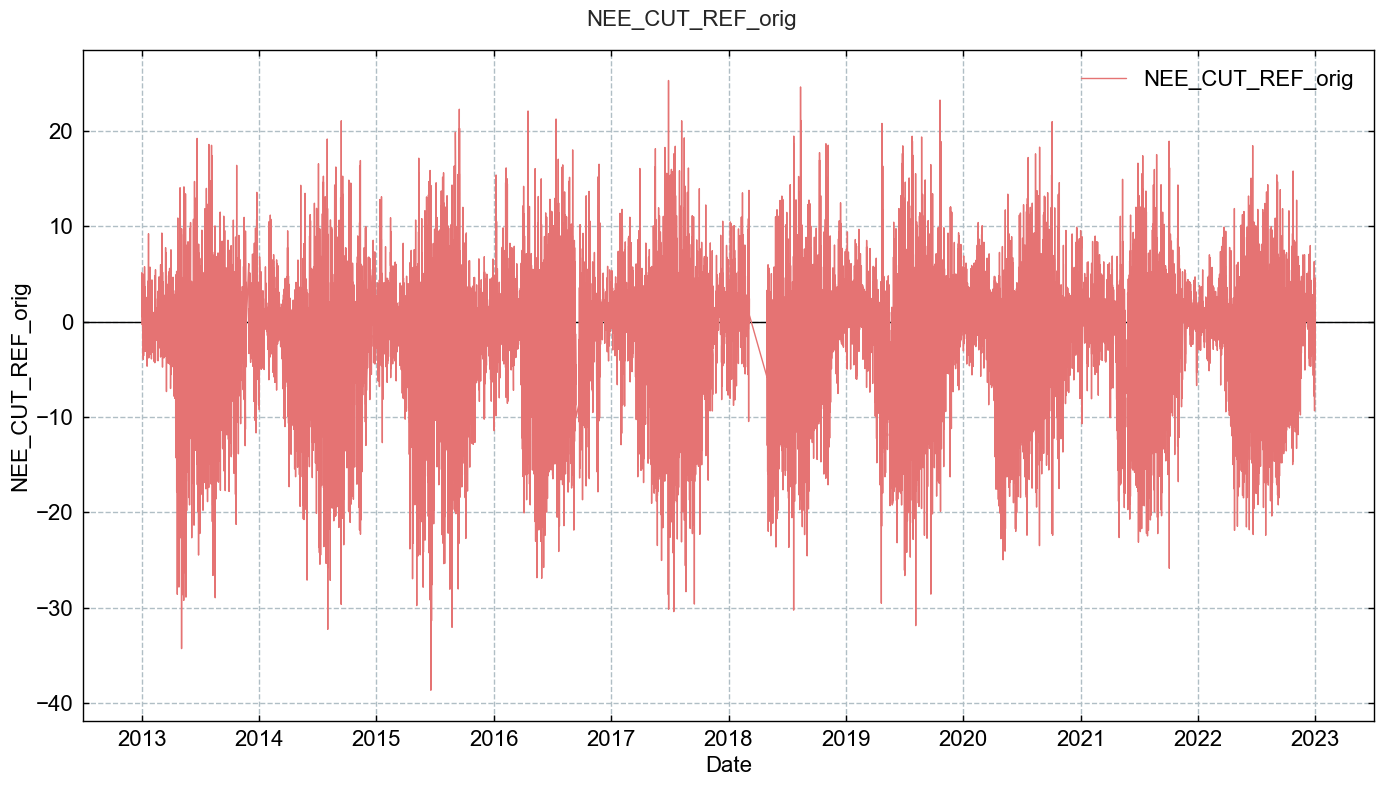

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize random forest

In [9]:
gf = LongTermGapFillingRandomForestTS(
        input_df=df,
        target_col=TARGET_COL,
        verbose=2,
        features_lag=[-1, -1],
        # features_lag=None,
        include_timestamp_as_features=True,        
        add_continuous_record_number=True,        
        sanitize_timestamp=True,
        perm_n_repeats=9,
        n_estimators=99,
        random_state=42,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1
    )


Adding new data columns ...
++ Added new columns with lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_CUT_REF_orig']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 20

</br>

## Assign yearpools

In [10]:
gf.create_yearpools()
gf.initialize_yearly_models()

[neighboring_years] Assigned [2013, 2014, 2015] to data pool for 2013.
[neighboring_years] Assigned [2013, 2014, 2015] to data pool for 2014.
[neighboring_years] Assigned [2014, 2015, 2016] to data pool for 2015.
[neighboring_years] Assigned [2015, 2016, 2017] to data pool for 2016.
[neighboring_years] Assigned [2016, 2017, 2018] to data pool for 2017.
[neighboring_years] Assigned [2017, 2018, 2019] to data pool for 2018.
[neighboring_years] Assigned [2018, 2019, 2020] to data pool for 2019.
[neighboring_years] Assigned [2019, 2020, 2021] to data pool for 2020.
[neighboring_years] Assigned [2020, 2021, 2022] to data pool for 2021.
[neighboring_years] Assigned [2020, 2021, 2022] to data pool for 2022.
Initializing model for 2013 ...
Initializing model for 2014 ...
Initializing model for 2015 ...
Initializing model for 2016 ...
Initializing model for 2017 ...
Initializing model for 2018 ...
Initializing model for 2019 ...
Initializing model for 2020 ...
Initializing model for 2021 ...
In

</br>

## Feature reduction

In [11]:
gf.reduce_features_across_years()

---
Reducing features based on permutation importance for year 2013 ...

Feature reduction based on permutation importance ...
>>> Calculating feature importances (permutation importance, 9 repeats) ...
>>> Setting threshold for feature rejection to 0.044326238497566194.
>>> Removing rejected features from model data ...
---
Reducing features based on permutation importance for year 2014 ...

Feature reduction based on permutation importance ...
>>> Calculating feature importances (permutation importance, 9 repeats) ...
>>> Setting threshold for feature rejection to 0.04432623849756618.
>>> Removing rejected features from model data ...
---
Reducing features based on permutation importance for year 2015 ...

Feature reduction based on permutation importance ...
>>> Calculating feature importances (permutation importance, 9 repeats) ...
>>> Setting threshold for feature rejection to 0.040948289955297784.
>>> Removing rejected features from model data ...
---
Reducing features based on p

</br>

## Fill gaps

In [12]:
gf.fillgaps()

Training model for 2013 ...

Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> based on data between 2013-01-01 06:15:00 and 2015-12-31 09:15:00 ...
>>> Fitting model to training data ...
>>> Using model to predict target NEE_CUT_REF_orig in unseen test data ...
>>> Using model to calculate permutation importance based on unseen test data ...
>>> Calculating prediction scores based on predicting unseen test data of NEE_CUT_REF_orig ...
>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.
Gap-filling 2013 ...

Gap-filling using final model ...
>>> Using final model on all data to predict target NEE_CUT_REF_orig ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting NEE_CUT_REF_orig ...
>>> Predicting target NEE_CUT_REF_orig where all features are available ... predicted 52560 records.
>>> 

</br>

## Results
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

### Dataframe with gap-filled time series

In [13]:
gf.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,1.305364,NaN,1.305364,1,1.305364,None,1.305364,1.305364
2013-01-01 00:45:00,1.305364,NaN,1.305364,1,1.305364,None,2.610727,1.305364
2013-01-01 01:15:00,1.318747,NaN,1.318747,1,1.318747,None,3.929475,1.318747
2013-01-01 01:45:00,1.239283,0.538,NaN,0,0.538000,None,4.467475,1.239283
2013-01-01 02:15:00,0.764242,NaN,0.764242,1,0.764242,None,5.231717,0.764242
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,0.909475,NaN,0.909475,1,0.909475,None,-8374.612798,0.909475
2022-12-31 22:15:00,0.182707,3.518,NaN,0,3.518000,None,-8371.094798,0.182707
2022-12-31 22:45:00,1.301657,NaN,1.301657,1,1.301657,None,-8369.793141,1.301657


### Gap-filled variable

In [14]:
print(f"The variable name of the gap-filled time series is {gf.gapfilled_.name}.")
gf.gapfilled_

The variable name of the gap-filled time series is NEE_CUT_REF_orig_gfRF.


TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.305364
2013-01-01 00:45:00    1.305364
2013-01-01 01:15:00    1.318747
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00    0.764242
                         ...   
2022-12-31 21:45:00    0.909475
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    1.301657
2022-12-31 23:15:00    1.189545
2022-12-31 23:45:00    2.244747
Freq: 30min, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

### Yearly data pools

In [15]:
gf.yearpools

{'2013': {'poolyears': [2013, 2014, 2015],
  'df':                      .DOY  .HOUR  .MONTH  .RECORDNUMBER  .Rg_f-1  .Tair_f-1  .VPD_f-1  .WEEK  .YEARDOY  .YEARMONTH  Rg_f  Tair_f  VPD_f  NEE_CUT_REF_orig
  TIMESTAMP_MIDDLE                                                                                                                                         
  2013-01-01 00:15:00     1      0       1              1      0.0     -1.618     1.339      1     20131       20131   0.0  -1.618  1.339               NaN
  2013-01-01 00:45:00     1      0       1              2      0.0     -1.618     1.339      1     20131       20131   0.0  -1.630  1.337               NaN
  2013-01-01 01:15:00     1      1       1              3      0.0     -1.630     1.337      1     20131       20131   0.0  -1.644  1.335               NaN
  2013-01-01 01:45:00     1      1       1              4      0.0     -1.644     1.335      1     20131       20131   0.0  -1.657  1.332             0.538
  2013-01-01 02

### Dictionary of yearly model instances

In [16]:
gf.results_yearly_

{'2013': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d9100dd0>,
 '2014': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a793a8f050>,
 '2015': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d8ffb490>,
 '2016': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d9684710>,
 '2017': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d95f6210>,
 '2018': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7e90d3090>,
 '2019': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d975b410>,
 '2020': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7e9b90590>,
 '2021': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d95f6650>,
 '2022': <diive.core.ml.common.MlRegressorGapFillingBase at 0x2a7d9744e90>}

### Test scores per year

In [17]:
gf.scores_

{'2013': {'mae': np.float64(1.271604545807851),
  'medae': np.float64(0.7800555555555513),
  'mse': np.float64(4.040342714128729),
  'rmse': np.float64(2.010060375742164),
  'mape': np.float64(912169026883.7728),
  'maxe': np.float64(23.63677777777778),
  'r2': 0.8983357567945683},
 '2014': {'mae': np.float64(1.271604545807851),
  'medae': np.float64(0.7800555555555495),
  'mse': np.float64(4.040342714128729),
  'rmse': np.float64(2.010060375742164),
  'mape': np.float64(912169026883.7728),
  'maxe': np.float64(23.63677777777778),
  'r2': 0.8983357567945683},
 '2015': {'mae': np.float64(1.2510115277344311),
  'medae': np.float64(0.7796363636363558),
  'mse': np.float64(3.8802232663712815),
  'rmse': np.float64(1.9698282327074312),
  'mape': np.float64(0.8362411819597724),
  'maxe': np.float64(27.548535353535357),
  'r2': 0.9027739046720459},
 '2016': {'mae': np.float64(1.2314184768793386),
  'medae': np.float64(0.7838636363636309),
  'mse': np.float64(3.700484377712464),
  'rmse': np.f

In [18]:
from statistics import mean
scores = []
r2s = []
print("SCORES PER YEAR")
for year, s in gf.scores_.items():
    print(f"{year}: r2 = {s['r2']}  MAE = {s['mae']}")
    scores.append(s['mae'])
    r2s.append(s['r2'])
print(f"{'-' * 20}\nMEAN MAE: {mean(scores)}\nMEAN r2: {mean(r2s)}")

SCORES PER YEAR
2013: r2 = 0.8983357567945683  MAE = 1.271604545807851
2014: r2 = 0.8983357567945683  MAE = 1.271604545807851
2015: r2 = 0.9027739046720459  MAE = 1.2510115277344311
2016: r2 = 0.9070517735942474  MAE = 1.2314184768793386
2017: r2 = 0.9133220011756611  MAE = 1.1838638906640377
2018: r2 = 0.9172322606745101  MAE = 1.162531021661778
2019: r2 = 0.9217006338074923  MAE = 1.1058928772845107
2020: r2 = 0.9161319464150421  MAE = 1.075645982441292
2021: r2 = 0.9200365747948611  MAE = 1.0235483619532502
2022: r2 = 0.9200365747948611  MAE = 1.0235483619532502
--------------------
MEAN MAE: 1.1600669592187591
MEAN r2: 0.9114957183517858


### Feature importances per year

In [19]:
gf.feature_importances_yearly_

{'2013':                PERM_IMPORTANCE   PERM_SD
 Rg_f                  1.168243  0.015312
 .DOY                  0.169415  0.002962
 .HOUR                 0.156025  0.002986
 .YEARDOY              0.155092  0.003978
 .VPD_f-1              0.117949  0.002286
 .RECORDNUMBER         0.103916  0.001722
 VPD_f                 0.097579  0.001547
 .Tair_f-1             0.096970  0.001431
 .Rg_f-1               0.082150  0.001421
 Tair_f                0.072551  0.001182
 .WEEK                 0.017499  0.000446
 .YEARMONTH            0.005160  0.000138
 .MONTH                0.003224  0.000139,
 '2014':                PERM_IMPORTANCE   PERM_SD
 Rg_f                  1.168243  0.015312
 .DOY                  0.169415  0.002962
 .HOUR                 0.156025  0.002986
 .YEARDOY              0.155092  0.003978
 .VPD_f-1              0.117949  0.002286
 .RECORDNUMBER         0.103916  0.001722
 VPD_f                 0.097579  0.001547
 .Tair_f-1             0.096970  0.001431
 .Rg_f-1         

### Features used in all models, after reduction

In [20]:
gf.features_reduced_across_years

['.DOY',
 '.HOUR',
 '.MONTH',
 '.RECORDNUMBER',
 '.Rg_f-1',
 '.Tair_f-1',
 '.VPD_f-1',
 '.WEEK',
 '.YEARDOY',
 '.YEARMONTH',
 'Rg_f',
 'Tair_f',
 'VPD_f']

### Feature ranks per year

In [21]:
gf.feature_ranks_per_year

YEAR,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
FEATURE,,,,,,,,,,
Rg_f,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
.DOY,2.0,2.0,2.0,2.0,3.0,2.0,2.0,7.0,7.0,7.0
.HOUR,3.0,3.0,3.0,4.0,6.0,6.0,6.0,5.0,6.0,6.0
.YEARDOY,4.0,4.0,10.0,11.0,11.0,10.0,12.0,11.0,11.0,11.0
.VPD_f-1,5.0,5.0,6.0,7.0,7.0,7.0,7.0,6.0,8.0,8.0
.RECORDNUMBER,6.0,6.0,9.0,8.0,9.0,9.0,10.0,8.0,10.0,10.0
VPD_f,7.0,7.0,7.0,9.0,10.0,8.0,8.0,9.0,9.0,9.0
.Tair_f-1,8.0,8.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,4.0
.Rg_f-1,9.0,9.0,5.0,6.0,8.0,5.0,5.0,4.0,2.0,2.0


### Feature importance per year

In [22]:
gf.feature_importance_per_year

YEAR,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
FEATURE,,,,,,,,,,
Rg_f,1.168243,1.168243,1.109659,0.998830,1.094371,1.089581,1.154516,1.308333,1.322998,1.322998
.DOY,0.169415,0.169415,0.249500,0.231515,0.168522,0.299566,0.252598,0.080831,0.078260,0.078260
.HOUR,0.156025,0.156025,0.157169,0.157277,0.112760,0.105377,0.109703,0.107149,0.122493,0.122493
.YEARDOY,0.155092,0.155092,0.038078,0.055832,0.032801,0.046559,0.024442,0.034831,0.027164,0.027164
.VPD_f-1,0.117949,0.117949,0.096447,0.083225,0.100520,0.105370,0.088578,0.089580,0.070994,0.070994
.RECORDNUMBER,0.103916,0.103916,0.067869,0.074358,0.061997,0.050191,0.043003,0.077281,0.044616,0.044616
VPD_f,0.097579,0.097579,0.086473,0.066795,0.054512,0.057250,0.065212,0.052827,0.053859,0.053859
.Tair_f-1,0.096970,0.096970,0.151978,0.167416,0.170341,0.186723,0.153774,0.182497,0.151721,0.151721
.Rg_f-1,0.082150,0.082150,0.106610,0.109402,0.081059,0.105803,0.114924,0.114141,0.171945,0.171945


### Plot: feature ranks per year

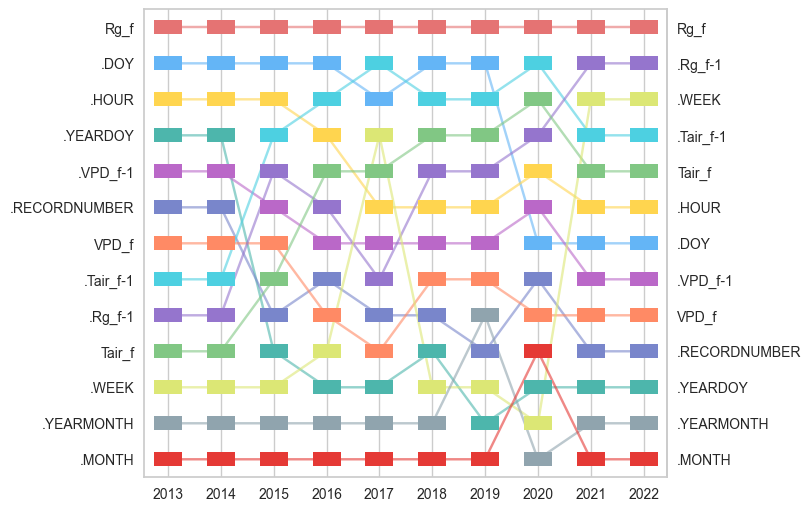

In [23]:
gf.showplot_feature_ranks_per_year()

</br>

</br>

## Plot

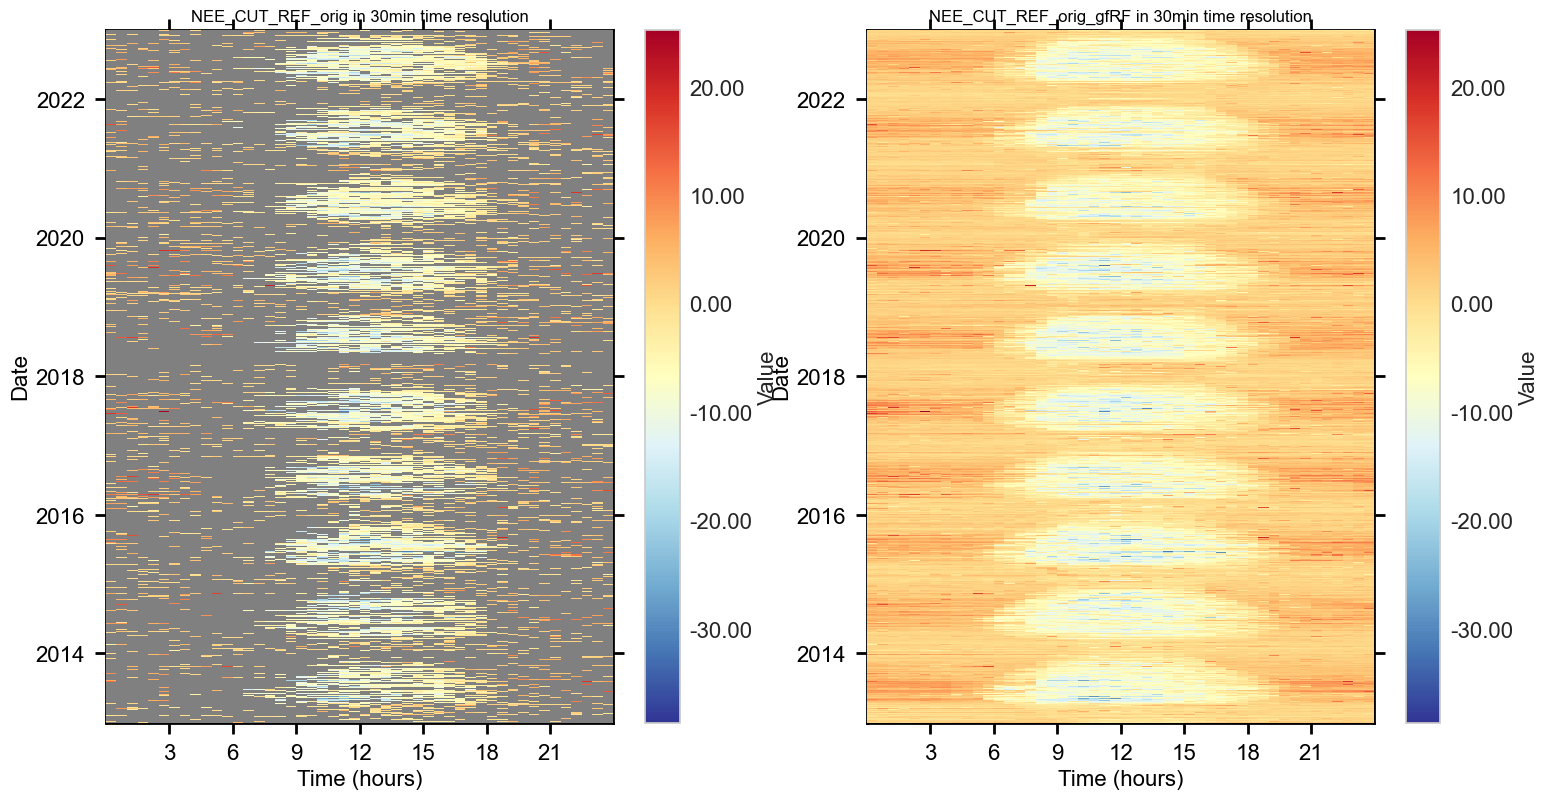

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gf.gapfilling_df_[gf.gapfilled_.name], ax=axs[1]).plot()

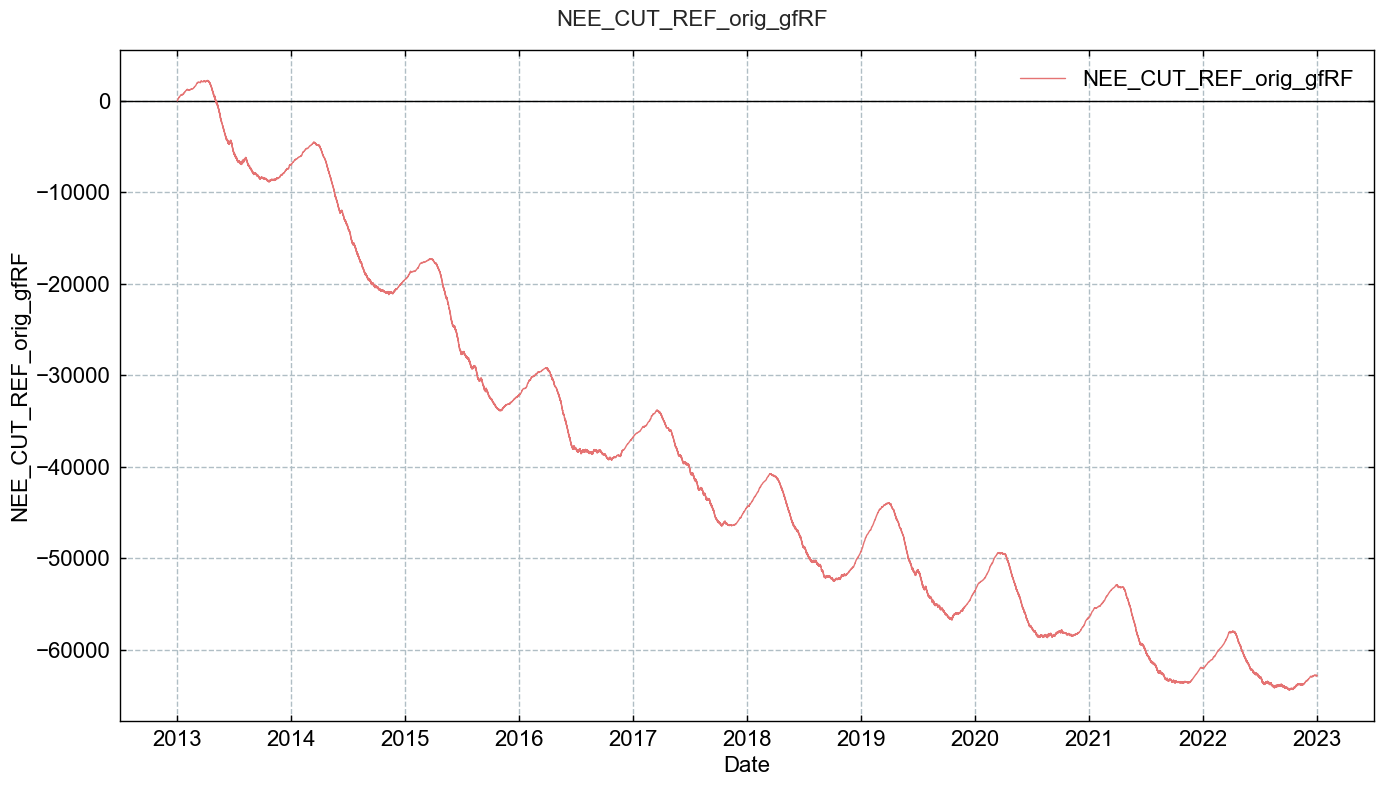

In [24]:
TimeSeries(series=gf.gapfilling_df_[gf.gapfilled_.name].cumsum()).plot()

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [25]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-10-24 17:36:28
